# Kings County Housing Prices Prediction


## Overview

This project will utilize multiple regression analysis to predict housing prices using data of homes sold in King County, WA, during 2014 and 2015. This dataset will be explored for completeness and integrity, relationships between attributes and target variable, and for feature engineering. Several models will be built and trained by SciKit python library to generate predictions on unseen data. A final model will be chosen based on its Root Mean Squared Error (RMSE) value. The data and project scope was provide by Flatiron School for Data Science Immersive program phase 2 final project.

The data set used for this project contains mix of continuous and categorical values. They are separated by columns and below is a summary of each columns. Further information on the meaning of each attribute can be found in the King County [website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r).

## Data Structure

- **id** - unique ID for a house
- **date** - Date day house was sold
- **price** - Price is prediction target
- **bedrooms** - Number of bedrooms
- **bathrooms** - Number of bathrooms
- **sqft_living** - square footage of the home
- **sqft_lot** - square footage of the lot
- **floors** - Total floors (levels) in house
- **waterfront** - ‘1’ if the property has a waterfront, ‘0’ if not.
- **view** - Number of times house has been viewed
- **condition** - 	Condition of the house, ranked from 1 to 5
- **grade** - 	Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value.
- **sqft_above** - square footage of house (apart from basement)
- **sqft_basement** - square footage of the basement
- **yr_built** - Year when house was built
- **yr_renovated** - Year when house was renovated
- **zipcode** - zip code in which house is located
- **lat** - Latitude coordinate
- **long** - Longitude coordinate
- **sqft_living15** - Average size of interior housing living space for the closest 15 houses, in square feet
- **sqft_lot15** - 	Average size of land lost for the closest 15 houses, in square feet



## Business Problem
A Seattle real estate company seeks to increase porfolio in King County, WA and wants to accurately predict the sales price of a property. Having an accurate sales prediction will aid in strategizing the investment options to maximize their profit. A multiple linaer regression model will be built base on provided property data for this task.

During the exploratory phase following questions will also be focused on:

1. What location in the county has the highest property value?
2. What aspects of the property brings value?
3. Do renovations have effect on property value?


## <center> Library and Data Import </center>

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from haversine import haversine
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
from scipy.stats import f_oneway

pd.options.display.max_columns = None

In [2]:
#read data and assigned column 0 as the column index
df = pd.read_csv('data/kc_house_data_train.csv',  index_col = 0)

## <center> Data Preperation <center/>
    
This section addresses extreme/outlier values, turning cathegorical data into dummies, and changing data types to the correct type.

### Extreme values

In [3]:
# Corrected all homes with 0 bedrooms and 0 bathrooms with a sqft living over 1,400. These were likely data errors.


# Replaced 0 bedrooms with 4
df['bedrooms'] = np.where(((df.sqft_living > 1400) & (df.bedrooms == 0)), 4, df.bedrooms)

# Replaced 0 bathrooms with 3
df['bathrooms'] = np.where(((df.sqft_living > 1400) & (df.bathrooms == 0)), 3, df.bathrooms)

In [4]:
# inspecting home with the 33 bedrooms.
df.loc[df.bedrooms == 33, :]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8597,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [5]:
# inspecting home with the 11 bedrooms.
df.loc[df.bedrooms == 11, :]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2356,1773100755,20140821T000000,520000.0,11,3.0,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.556,-122.363,1420,4960


In [6]:
#replaced 33 with 3 bedrooms after  checking property in Zillow page.
df['bedrooms'] = df.bedrooms.replace({33:3})

#replaced 11 with 4 bedrooms after  checking property in Zillow page.
df['bedrooms'] = df.bedrooms.replace({11:4})

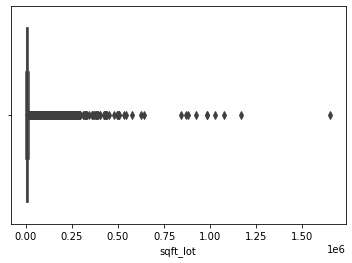

In [7]:
sns.boxplot(x=df.sqft_lot)

In [8]:
#use np.where to replace all sqft_lot above 650,00 with 650,000
df['sqft_lot'] = np.where(df.sqft_lot > 650000, 650000, df.sqft_lot)

### Dummie Variables

In [9]:
# Zip code dummies and droped 1 column 98103
df_dummy = pd.get_dummies(df.zipcode).drop(columns = 98103)
df = pd.concat([df, df_dummy], 1)

### Changing Data types

In [10]:
#Transformed date column to Pandas datetime format
df['date'] = pd.to_datetime(df.date)

## <center> Exploratory Data Analysis <center/>
    
This section will seek to answer the questions listed in business problems. The data will be visualized for easy understanding and followed with appropriate statistical analysis for empirical findings within data. Following are the summaries of the questions answered in this section:

1. Are the prices for properties closer to city hubs more expensive?
2. Does the grade of the property affect the value?
3. What features add value to the house?
    - Do renovations increase property value?

In [11]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
#Checking for null values. No null values identified
df.isna().sum()

id           0
date         0
price        0
bedrooms     0
bathrooms    0
            ..
98177        0
98178        0
98188        0
98198        0
98199        0
Length: 90, dtype: int64

In [13]:
# inspect firts few rows
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
df.shape

(17290, 90)

In [15]:
#check for duplicated data
df.duplicated().sum()

0

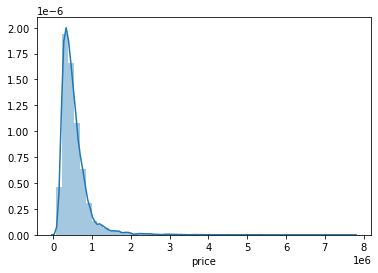

In [16]:
#checking for normality of target variable. Extreme price values skew the price distribution to the right.
sns.distplot(df.price) #take log of price. Check log rmse vs non-log

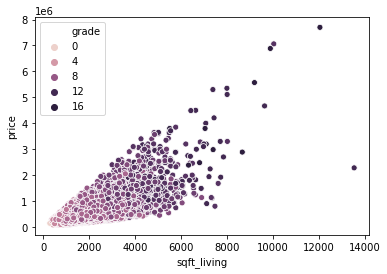

In [17]:
#The graph below show a strong positive correcation between sqft_living and the price of the home. Also,
sns.scatterplot(x = df['sqft_living'], y=df['price'], hue=df['grade'])


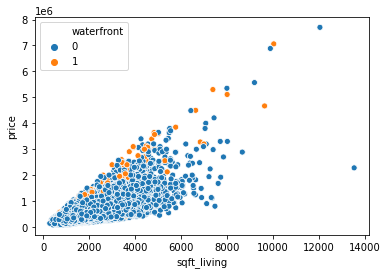

In [18]:
#It appears that propertries with waterfront tend to be on the more expensive side and have larger sqrt_living
sns.scatterplot(x = df['sqft_living'], y=df['price'], hue=df['waterfront'])

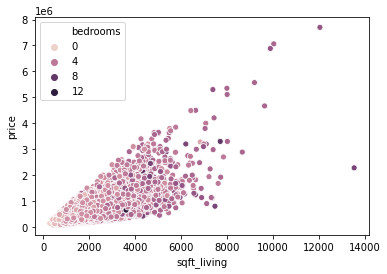

In [19]:
#It appears that propertries with higher number of bedrooms tend to be on the more expensive side and have larger sqrt_living
sns.scatterplot(x = df['sqft_living'], y=df['price'], hue=df['bedrooms'])

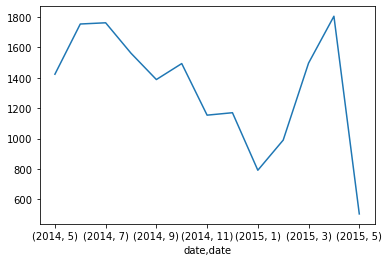

In [113]:
#Count of houses sold by year and month. Checking for sales trend overtime in King County.The number of home sales appear to peak between the months of June through August.
df.groupby([df.date.dt.year, df.date.dt.month]).price.count().plot(kind='line')

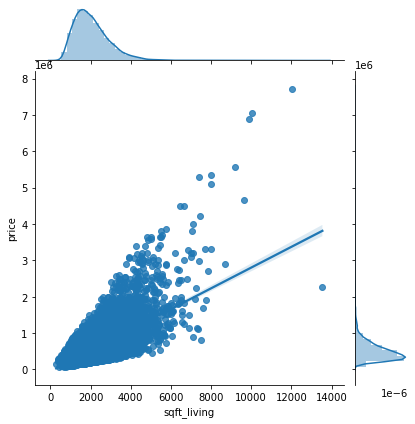

In [21]:
#sqft_living is postively correlated with home prices
sns.jointplot('sqft_living', 'price', data=df, kind='reg' )

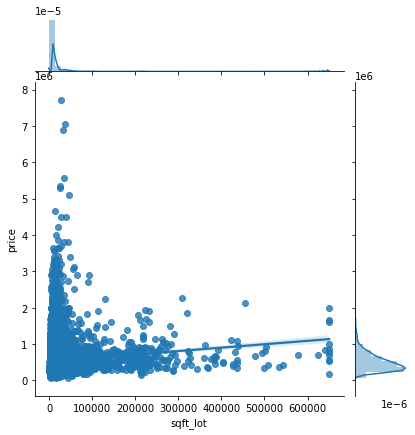

In [22]:
#sqft_lot is also postively correlated with home prices, but the correlation is weaker than sqft_lot.
sns.jointplot('sqft_lot', 'price', data=df, kind='reg' )

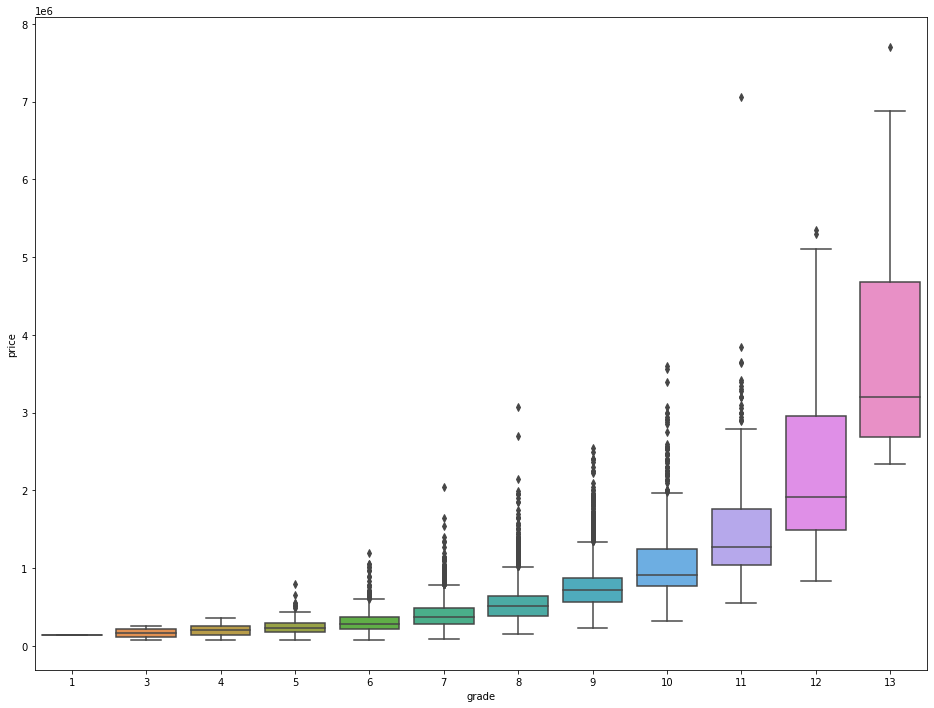

In [23]:
# this plot demontrates a clear positive relationship between grade and home prices.
plt.figure(figsize=(16,12))
sns.boxplot(x='grade', y='price', data=df)

In [24]:
#outlier - legitamate because of features such as  number of bedrooms, bathrooms, floors, etc
df[df.grade == 11].price.max()
df[df.price == 7062500.0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
6903,9808700762,2014-06-11,7062500.0,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


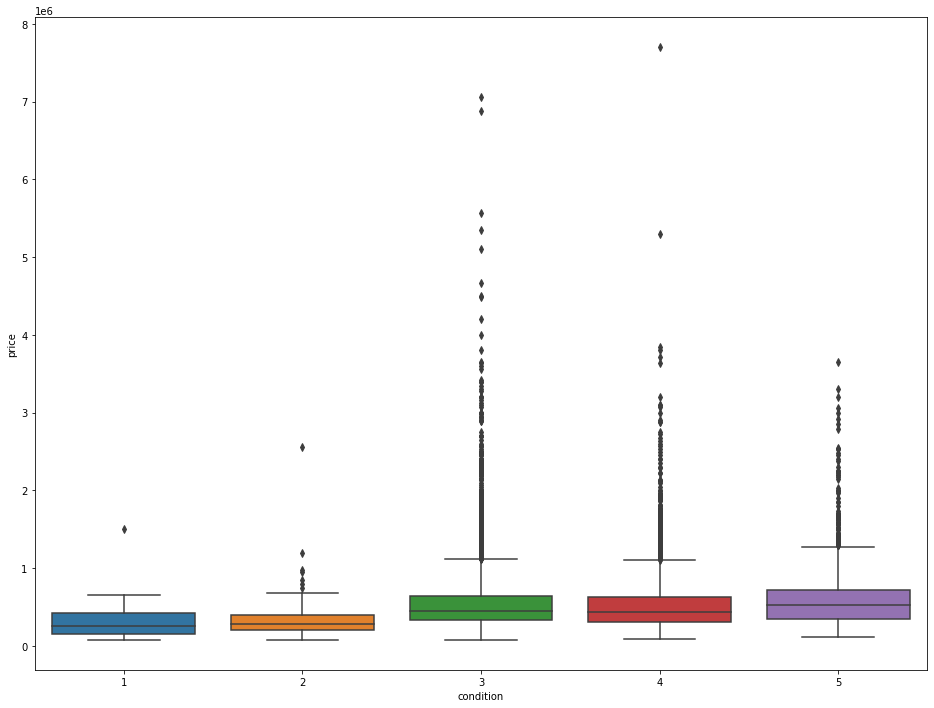

In [25]:
plt.figure(figsize=(16,12))
sns.boxplot(x='condition', y='price', data=df)

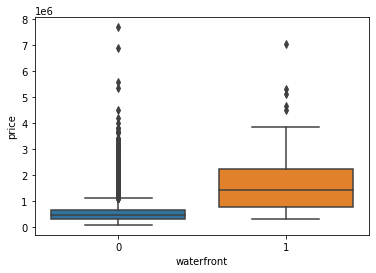

In [26]:
sns.boxplot(x='waterfront', y='price', data=df)

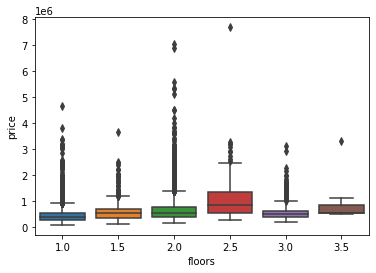

In [27]:
sns.boxplot(x='floors', y='price', data=df)

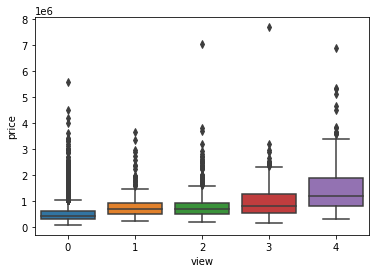

In [28]:
sns.boxplot(x='view', y='price', data=df)

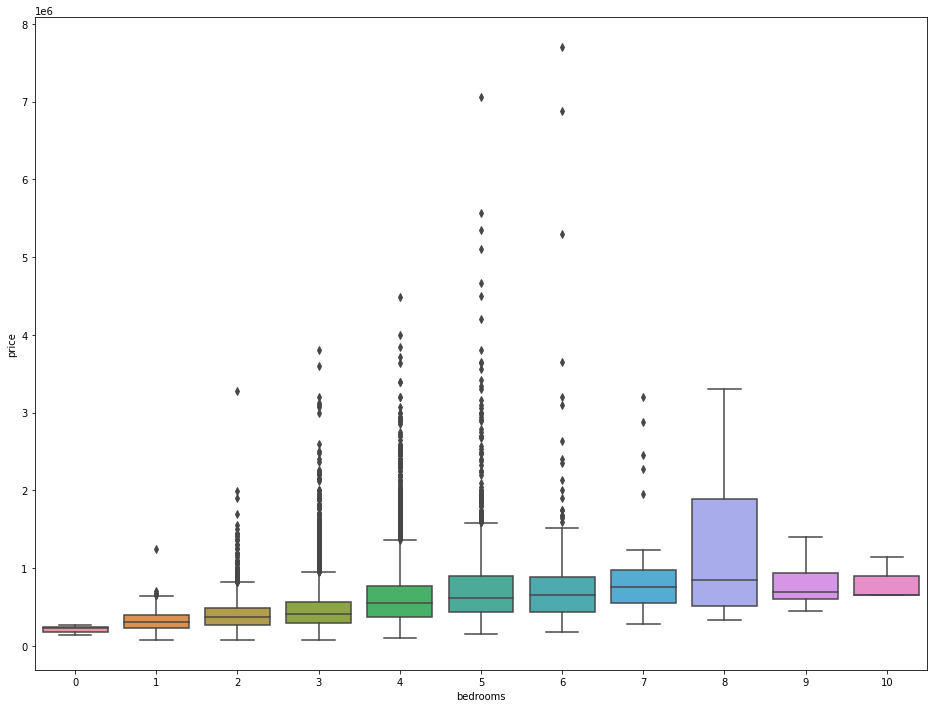

In [29]:
plt.figure(figsize=(16,12))
sns.boxplot(x='bedrooms', y='price', data=df)

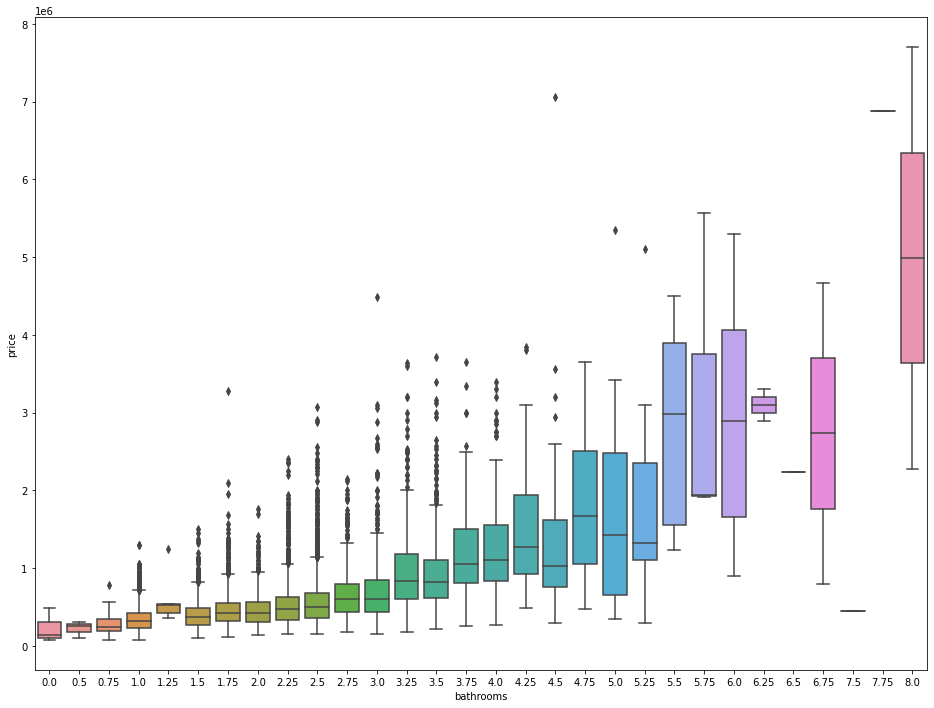

In [30]:
plt.figure(figsize=(16,12))
sns.boxplot(x='bathrooms', y='price', data=df)

In [31]:
df[df.sqft_living > 12000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
3275,1225069038,2014-05-05,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10366,6762700020,2014-10-13,7700000.0,6,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
df[df.sqft_lot == 1651359]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199


## <center> Statistical Test <center/>

### Waterfront and Price

In [129]:
# computation of the two-sample t-statistics of the mean prices for properties with and without waterfront views.
price_n_waterfront = df[df.waterfront == 0].price
price_y_waterfront = df[df.waterfront == 1].price

t, p = ttest_ind(price_n_waterfront, price_y_waterfront, equal_var=False)

print('Null Hypothesis: The mean price of properties with and without waterfront views are equal.')
print('Alternate Hypothesis: The mean price of properties with and without waterfront views are not equal.')
print('\nT-statistic: ' + str(t))
print('\nP-value: ' + str(p))
print('\nResults: With a 95% confidence level, we can reject the null hypothesis that the mean price of properties with and without waterfront views are equal.')

Null Hypothesis: The mean price of properties with and without waterfront views are equal.
Alternate Hypothesis: The mean price of properties with and without waterfront views are not equal.

T-statistic: -11.903695918563983

P-value: 6.940441256090536e-23

Results: With a 95% confidence level, we can reject the null hypothesis that the mean price of properties with and without waterfront views are equal.


### Grade level and price

In [117]:
np.sort(df.grade.unique())

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64)

In [130]:
# computation of the f-statistic and p-value of the mean prices for all grade levels.
grade_1_price = df[df.grade == 1].price
grade_2_price = df[df.grade == 3].price
grade_4_price = df[df.grade == 4].price
grade_5_price = df[df.grade == 5].price
grade_6_price = df[df.grade == 6].price
grade_7_price = df[df.grade == 7].price
grade_8_price = df[df.grade == 8].price
grade_9_price = df[df.grade == 9].price
grade_10_price = df[df.grade == 10].price
grade_11_price = df[df.grade == 11].price
grade_12_price = df[df.grade == 12].price
grade_13_price = df[df.grade == 13].price

t, pval = f_oneway(
    grade_1_price, grade_2_price, grade_4_price, grade_5_price, grade_6_price, grade_7_price, grade_8_price,
    grade_9_price, grade_10_price, grade_11_price, grade_12_price, grade_13_price

)
print('Null Hypothesis: The mean price of properties with grade levels 1 through 13 are equal.')
print('Alternate Hypothesis: The mean price of properties with grade levels 1 through 13 are not equal.')

print('\nF-statistic: ' + str(t))
print('\nP-value: ' + str(p))

print('\nResults: With a 95% confidence level, we can reject the null hypothesis The mean price of properties with grade levels 1 through 13 are equal.')

Null Hypothesis: The mean price of properties with grade levels 1 through 13 are equal.
Alternate Hypothesis: The mean price of properties with grade levels 1 through 13 are not equal.

F-statistic: 1763.5110290471393

P-value: 6.940441256090536e-23

Results: With a 95% confidence level, we can reject the null hypothesis The mean price of properties with grade levels 1 through 13 are equal.


### Renovations and Price

In [134]:
# computation of the two-sample t-statistics of the mean prices for properties that were and were not renovated.

prices_renovated = df[df.renovated_flg == 0].price
prices_not_renovated = df[df.renovated_flg == 1].price

t, p = ttest_ind(prices_renovated, prices_not_renovated, equal_var=False)

print('Null Hypothesis: The mean price of properties that were renovated and not renovated are equal.')
print('Alternate Hypothesis: The mean price of properties that were renovated and not renovated are not equal.')
print('\nT-statistic: ' + str(t))
print('\nP-value: ' + str(p))
print('\nResults: With a 95% confidence level, we can reject the null hypothesis that the mean price of properties that were renovated and not renovated are equal.')

Null Hypothesis: The mean price of properties that were renovated and not renovated are equal.
Alternate Hypothesis: The mean price of properties that were renovated and not renovated are not equal.

T-statistic: 9.400954343413524

P-value: 6.478917377975333e-20

Results: With a 95% confidence level, we can reject the null hypothesis that the mean price of properties that were renovated and not renovated are equal.


## <center> Feature Engineering <center/>

    
### Grade

In [33]:
#Defining groups of the grade feature as 1 to 5, 6, 7, 8, 9, 10, and 11 to 13
np.sort(df.grade.unique())

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64)

In [34]:
conditions = [
    ((df.grade >=1) & (df.grade <=5)),
    df.grade == 6,
    df.grade == 7,
    df.grade == 8,
    df.grade == 9,
    df.grade == 10,
    ((df.grade >=11) & (df.grade <=13))
]

choices = [
    1,
    2,
    3,
    4,
    5,
    6,
    7    
]

df['grade_new'] = np.select(conditions, choices)

### Distance from city hubs

In [35]:
#Computing the distancing of properties from the main cities' hub, including seattle and bellevue. The closer a property is to city a hub, the more expensive it is likely to be.
df['lat_long'] = tuple(zip(df.lat,df.long))
seattle = [47.6092, -122.3363]
bellevue = [47.61555, -122.20392]

In [36]:
seattle_distances = []
for i in df['lat_long']:
    seattle_distances.append(haversine((seattle), (i), unit = 'mi'))
df['distance_from_seattle'] = pd.Series(seattle_distances)

bellevue_distances = []
for i in df['lat_long']:
    bellevue_distances.append(haversine((bellevue), (i), unit = 'mi'))
df['distance_from_bellevue'] = pd.Series(bellevue_distances)

In [37]:
df['distance_from_epicenter'] = df[['distance_from_bellevue', 'distance_from_seattle']].min(axis=1)

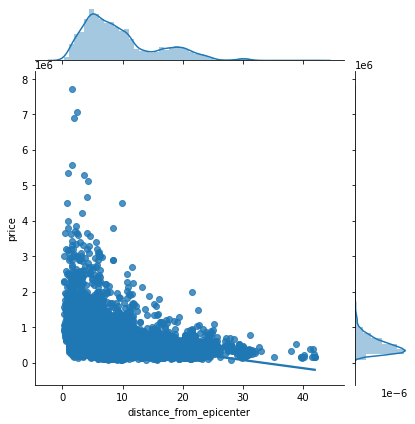

In [38]:
# There appears to be a slight negative correlation between distance from city hubs and home prices. The farther a properties's distance is away from seattle and Bellevue, the less expensive, on average, it tends to be.
sns.jointplot('distance_from_epicenter', 'price', data=df, kind='reg')

### Age of homes

In [39]:
df['age'] = 2016 - df.yr_built

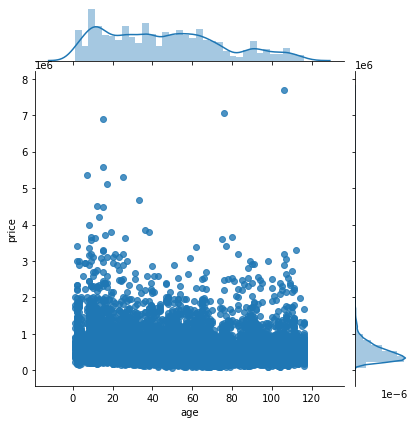

In [40]:
sns.jointplot('age', 'price', data=df, kind='reg' )

### Renovation flag

In [41]:
df.yr_renovated.value_counts()

0       16564
2014       71
2007       32
2005       32
2000       31
        ...  
1934        1
1959        1
1944        1
1951        1
1948        1
Name: yr_renovated, Length: 69, dtype: int64

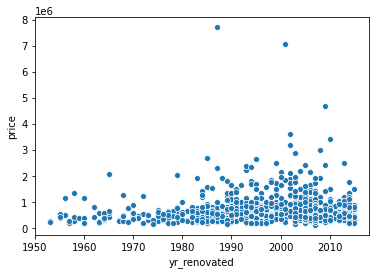

In [42]:


#sns.scatterplot(data=df, x=(df.yr_renovated > 1970), y='price')

rect_ren=df[df.yr_renovated > 1951]

# Properties with more recent renovations tend to be slightly more expensive on average.
sns.scatterplot(data=rect_ren, x='yr_renovated', y='price')

In [43]:
df['renovated_flg'] = np.where(df.yr_renovated == 0, 1, 0)

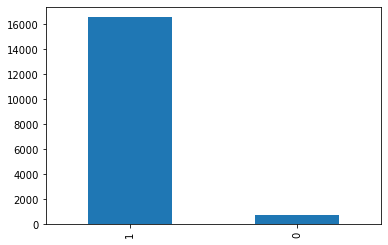

In [44]:
df.renovated_flg.value_counts().plot(kind='bar')

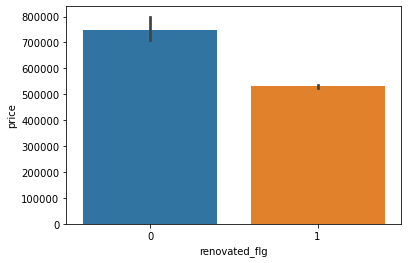

In [45]:
sns.barplot(x='renovated_flg', y='price', data=df )

### Polynomials and Interactions

In [46]:
# your code here
df_features = df.loc[:, ~df.columns.isin(['id','date', 'price', 'distance_from_seattle', 'distance_from_bellevue', 'lat_long', 'zipcode'])]
df_features.shape

(17290, 90)

In [47]:
c = [               'bedrooms',               'bathrooms',
                   'sqft_living',                'sqft_lot',
                        'floors',              'waterfront',
                          'view',               'condition',
                         'grade',              'sqft_above',
                 'sqft_basement',                'yr_built',
                  'yr_renovated',                     'lat',
                          'long',           'sqft_living15',
                    'sqft_lot15', 'distance_from_epicenter',
                           'age',           'renovated_flg',
                           98001,                     98002,
                           98003,                     98004,
                           98005,                     98006,
                           98007,                     98008,
                           98010,                     98011,
                           98014,                     98019,
                           98022,                     98023,
                           98024,                     98027,
                           98028,                     98029,
                           98030,                     98031,
                           98032,                     98033,
                           98034,                     98038,
                           98039,                     98040,
                           98042,                     98045,
                           98052,                     98053,
                           98055,                     98056,
                           98058,                     98059,
                           98065,                     98070,
                           98072,                     98074,
                           98075,                     98077,
                           98092,                     98102,
                           98105,                     98106,
                           98107,                     98108,
                           98109,                     98112,
                           98115,                     98116,
                           98117,                     98118,
                           98119,                     98122,
                           98125,                     98126,
                           98133,                     98136,
                           98144,                     98146,
                           98148,                     98155,
                           98166,                     98168,
                           98177,                     98178,
                           98188,                     98198,
                           98199]

In [48]:
[x for x in df_features.columns if x not in c]

['grade_new']

In [49]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [50]:
poly_data = poly.fit_transform(df_features)

In [51]:
poly_data.shape

(17290, 4185)

In [52]:
df_features.columns = df_features.columns.map(str)
poly_columns = poly.get_feature_names(df_features.columns)

In [53]:
df_poly = pd.DataFrame(poly_data, columns=poly_columns)

In [54]:
df_poly.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       4.0       2.25       2070.0    8893.0     2.0         0.0   0.0   
1       5.0       3.00       2900.0    6730.0     1.0         0.0   0.0   
2       4.0       2.50       3770.0   10893.0     2.0         0.0   2.0   
3       3.0       3.50       4560.0   14608.0     2.0         0.0   2.0   
4       3.0       2.50       2550.0    5376.0     2.0         0.0   0.0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0        4.0    8.0      2070.0            0.0    1986.0           0.0   
1        5.0    8.0      1830.0         1070.0    1977.0           0.0   
2        3.0   11.0      3770.0            0.0    1997.0           0.0   
3        3.0   12.0      4560.0            0.0    1990.0           0.0   
4        3.0    9.0      2550.0            0.0    2004.0           0.0   

       lat     long  sqft_living15  sqft_lot15  98001  98002  98003  98004  \
0  47.4388 -122.162         2390.0      7700.0    0.0    0.0    0.0    0.0   
1  47.6784 -122.285         2370.0      6283.0    0.0    0.0    0.0    0.0   
2  47.5646 -122.129         3710.0      9685.0    0.0    0.0    0.0    0.0   
3  47.6995 -122.228         4050.0     14226.0    0.0    0.0    0.0    0.0   
4  47.6647 -122.083         2250.0      4050.0    0.0    0.0    0.0    0.0   

   98005  98006  98007  98008  98010  98011  98014  98019  98022  98023  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   98024  98027  98028  98029  98030  98031  98032  98033  98034  98038  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   98039  98040  98042  98045  98052  98053  98055  98056  98058  98059  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

   98065  98070  98072  98074  98075  98077  98092  98102  98105  98106  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   98107  98108  98109  98112  98115  98116  98117  98118  98119  98122  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   98125  98126  98133  98136  98144  98146  98148  98155  98166  98168  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0

In [55]:
# polynomials for only continues variables


## <center> Linear Regression <center/>

### Training and Test Data Setup



In [56]:
#call train_test_split on the data and capture the results
target = df.price

#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(df_poly, target, random_state=34, test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (13832, 4185) Target:  (13832,)
Training set - Features:  (3458, 4185) Target:  (3458,)


In [57]:
scaler = StandardScaler()
target_log = np.log(df.price)

# Did a seperate train, test, split on the loged tarted, and then I scalled the train and test data.
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_poly, target_log, random_state=34, test_size=0.2)

#fit and transform the training data
X_train1 = pd.DataFrame(data=scaler.fit_transform(X_train1), columns=df_poly.columns)

In [58]:
#transferm the testing data
X_test1 = pd.DataFrame(data=scaler.transform(X_test1), columns=df_poly.columns)


In [59]:
#instantiate a linear regression object
linreg = LinearRegression()

#fit the linear regression to the data
linreg = linreg.fit(X_train, y_train)

print(linreg.intercept_)
print(linreg.coef_)

426026606451.4147
[-1.44731628e+03  2.69643155e+04 -8.36200563e+04 ... -3.12101790e+02
  1.55261575e+06  1.52115920e+03]


In [60]:
#pairing the feature names with the coefficients
list(zip(df_poly.columns, linreg.coef_))

[('bedrooms', -1447.3162766157557),
 ('bathrooms', 26964.31551200527),
 ('sqft_living', -83620.05628290986),
 ('sqft_lot', 10061.217088981788),
 ('floors', 18209.810103215492),
 ('waterfront', -16158.154915562554),
 ('view', -15067.657604939697),
 ('condition', 18801.77707755021),
 ('grade', 8655.508387367081),
 ('sqft_above', -37916.90629794261),
 ('sqft_basement', 5952.348270413851),
 ('yr_built', 3735.690709056083),
 ('yr_renovated', -1630.7882291421959),
 ('lat', -18950.86876986877),
 ('long', -21319.995933048227),
 ('sqft_living15', 1869.503846671824),
 ('sqft_lot15', -4021.1732115559726),
 ('98001', -1181.1797219382875),
 ('98002', -2409.078481264717),
 ('98003', 1668.7292097357727),
 ('98004', -3247.5225796265327),
 ('98005', -1932.1679154782173),
 ('98006', -2337.436673776949),
 ('98007', -2623.4357907962103),
 ('98008', -2333.092359832877),
 ('98010', -4063.6990325235097),
 ('98011', -2385.5373646288253),
 ('98014', -2568.6503422252526),
 ('98019', -2270.855623487244),
 ('9802

### 5.5) Use the model to predict on the training set and the test set.

In [61]:
#your code here 
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

### 5.6) Evaluate the training and test predictions using RMSE.

In [62]:
#your code here 

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training: ', int(train_rmse), 'vs. Testing', int(test_rmse))

Training:  89387 vs. Testing 153922


### 5.7) Determine if your model is overfit.

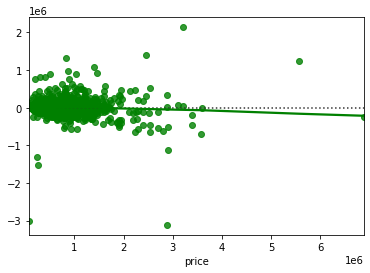

In [63]:
#your code here 
sns.residplot(x = y_test, y=y_test_pred, lowess=True, color = 'g')

(array([1.000e+00, 6.000e+00, 4.000e+01, 3.295e+03, 1.020e+02, 9.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([-1893418.70666504, -1371010.01555176,  -848601.32443848,
         -326192.6333252 ,   196216.05778809,   718624.74890137,
         1241033.44001465,  1763442.13112793,  2285850.82224121,
         2808259.51335449,  3330668.20446777]),
 <a list of 10 Patch objects>)

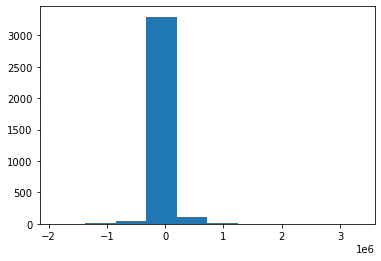

In [64]:
plt.hist(y_test - y_test_pred)

### <center> VIF <center/>

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [65]:
# Check VIF of features

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
vif['features'] = df_features.columns
vif.sort_values(by='VIF Factor', ascending=False).head(20)

C:\Users\edwar\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
2,inf,sqft_living
9,inf,sqft_above
10,inf,sqft_basement
11,4.909761e+07,yr_built
88,3.668818e+04,age
12,1.597812e+04,yr_renovated
89,1.597731e+04,renovated_flg
8,1.650249e+02,grade
86,1.622988e+02,grade_new
13,6.993989e+01,lat


In [66]:
X_train.shape

(13832, 4185)

In [67]:
selector = SelectKBest(f_regression, k=50)

selector.fit(X_train, y_train)

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\edwar\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=50, score_func=<function f_regression at 0x000001C35B152280>)

In [68]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [69]:
list(removed_columns)

['bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_lot15',
 '98001',
 '98002',
 '98003',
 '98004',
 '98005',
 '98006',
 '98007',
 '98008',
 '98010',
 '98011',
 '98014',
 '98019',
 '98022',
 '98023',
 '98024',
 '98027',
 '98028',
 '98029',
 '98030',
 '98031',
 '98032',
 '98033',
 '98034',
 '98038',
 '98039',
 '98040',
 '98042',
 '98045',
 '98052',
 '98053',
 '98055',
 '98056',
 '98058',
 '98059',
 '98065',
 '98070',
 '98072',
 '98074',
 '98075',
 '98077',
 '98092',
 '98102',
 '98105',
 '98106',
 '98107',
 '98108',
 '98109',
 '98112',
 '98115',
 '98116',
 '98117',
 '98118',
 '98119',
 '98122',
 '98125',
 '98126',
 '98133',
 '98136',
 '98144',
 '98146',
 '98148',
 '98155',
 '98166',
 '98168',
 '98177',
 '98178',
 '98188',
 '98198',
 '98199',
 'distance_from_epicenter',
 'age',
 'renovated_flg',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms sqft_lot',
 'bedrooms floors',
 'bedro

In [70]:
list(selected_columns)

['sqft_living',
 'grade',
 'sqft_above',
 'sqft_living15',
 'grade_new',
 'bedrooms sqft_living',
 'bedrooms sqft_above',
 'bedrooms sqft_living15',
 'bedrooms grade_new',
 'bathrooms^2',
 'bathrooms sqft_living',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_living15',
 'bathrooms grade_new',
 'sqft_living^2',
 'sqft_living floors',
 'sqft_living condition',
 'sqft_living grade',
 'sqft_living sqft_above',
 'sqft_living yr_built',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living sqft_living15',
 'sqft_living grade_new',
 'condition sqft_above',
 'condition sqft_living15',
 'condition grade_new',
 'grade^2',
 'grade sqft_above',
 'grade yr_built',
 'grade lat',
 'grade long',
 'grade sqft_living15',
 'grade grade_new',
 'sqft_above^2',
 'sqft_above yr_built',
 'sqft_above lat',
 'sqft_above long',
 'sqft_above sqft_living15',
 'sqft_above grade_new',
 'yr_built sqft_living15',
 'yr_built grade_new',
 'lat sqft_living15',
 'lat grade_new',
 'long sqft_living15',
 '

### Recursive Feature Elimination

In [71]:
# Recursive feature Selection

ols = LinearRegression()

selector = RFECV(estimator=ols, step=1, cv=7, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

selector.fit(X_train[selected_columns], y_train)

Fitting estimator with 50 features.


RFECV(cv=7, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)

In [72]:
selected_rfe = X_train[selected_columns].columns[selector.support_]
removed_rfe = X_train[selected_columns].columns[~selector.support_]

In [73]:
selected_rfe

Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'grade_new',
       'bedrooms sqft_living', 'bedrooms sqft_above', 'bedrooms sqft_living15',
       'bedrooms grade_new', 'bathrooms^2', 'bathrooms sqft_living',
       'bathrooms grade', 'bathrooms sqft_above', 'bathrooms sqft_living15',
       'bathrooms grade_new', 'sqft_living^2', 'sqft_living floors',
       'sqft_living condition', 'sqft_living grade', 'sqft_living sqft_above',
       'sqft_living yr_built', 'sqft_living lat', 'sqft_living long',
       'sqft_living grade_new', 'condition sqft_above',
       'condition sqft_living15', 'condition grade_new', 'grade^2',
       'grade sqft_above', 'grade yr_built', 'grade lat', 'grade long',
       'grade sqft_living15', 'grade grade_new', 'sqft_above^2',
       'sqft_above yr_built', 'sqft_above lat', 'sqft_above long',
       'sqft_above sqft_living15', 'sqft_above grade_new',
       'yr_built sqft_living15', 'yr_built grade_new', 'lat sqft_living15',
       'lat grade_

### Kbest Feature Selection

In [74]:
#instantiate a linear regression object
linreg_kbest = LinearRegression()

#fit the linear regression to the data
linreg_kbest.fit(X_train1[selected_columns], y_train1)

y_train_kbest = linreg_kbest.predict(X_train1[selected_columns])

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train1, y_train_kbest))

print('Training Root Mean Squared Error: ', trainK_rmse)

y_test_kbest = linreg_kbest.predict(X_test1[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test1, y_test_kbest))

print('Testing Root Mean Squared Error: ', testK_rmse)

Training Root Mean Squared Error:  0.2518273078404012
Testing Root Mean Squared Error:  0.260306932342599


In [75]:
#exponentiating RMSE value
trainK_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_train1), np.exp(y_train_kbest)))
trainK_rmse

189672.13032847605

In [76]:
#exponentiating RMSE value
testK_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test1), np.exp(y_test_kbest)))
testK_rmse

213527.53811949794

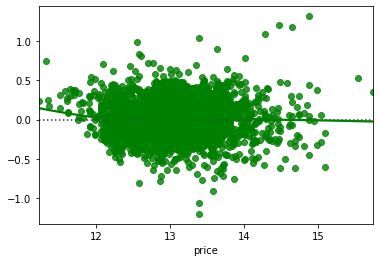

In [77]:
sns.residplot(x = y_test1, y=y_test_kbest, lowess=True, color = 'g')

In [78]:
# Recursive feature Selection fit
linreg_rfe = LinearRegression()

linreg_rfe = linreg_rfe.fit(X_train1[selected_rfe], y_train1)

y_rfe = linreg_rfe.predict(X_train1[selected_rfe])

trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train1, y_rfe))

print('Training Rood Mean Squared Error: ', trainRFE_rmse)

y_pred_rfe = linreg_rfe.predict(X_test1[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test1, y_pred_rfe))

print('Testing Root Mean Squared Error: ', testRFE_rmse)

Training Rood Mean Squared Error:  0.25182785261557855
Testing Root Mean Squared Error:  0.26029356161282835


In [79]:
#exponentiating RMSE value
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_train1), np.exp(y_rfe)))
trainRFE_rmse

189679.1867017646

In [80]:
#exponentiating RMSE value
testRFE_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test1), np.exp(y_pred_rfe)))
testRFE_rmse

213446.264156978

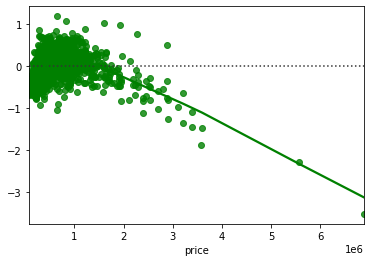

In [81]:
sns.residplot(x = y_test, y=y_pred_rfe, lowess=True, color = 'g')

In [82]:
lasso = Lasso(alpha=0.01, normalize=False)

lasso = lasso.fit(X_train1[selected_rfe], y_train1)

y_train_pred_lasso = lasso.predict(X_train1[selected_rfe])
y_pred_lasso = lasso.predict(X_test1[selected_rfe])

train_rmse_lasso01 = np.sqrt(metrics.mean_absolute_error(y_train1, y_train_pred_lasso))
test_rmse_lasso01 = np.sqrt(metrics.mean_absolute_error(y_test1, y_pred_lasso))

print('Training Error: ' + str(train_rmse_lasso01))
print('Testing Error: ' + str(test_rmse_lasso01))

Training Error: 0.5192435487141935
Testing Error: 0.5248111890606649


In [83]:
f =  lasso.coef_ != 0
f.sum()

6

In [84]:
train_rmse_lasso01 = np.sqrt(metrics.mean_absolute_error(np.exp(y_train1), np.exp(y_train_pred_lasso)))
train_rmse_lasso01

378.9404561646843

In [85]:
test_rmse_lasso01 = np.sqrt(metrics.mean_absolute_error(np.exp(y_test1), np.exp(y_pred_lasso)))
test_rmse_lasso01

384.39507705273934

In [86]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.00001, normalize=False)

ridge = ridge.fit(X_train1[selected_rfe], y_train1)

y_train_pred_ridge = ridge.predict(X_train1[selected_rfe])
y_pred_ridge = ridge.predict(X_test1[selected_rfe])

train_rmse_ridge = np.sqrt(metrics.mean_squared_error(np.exp(y_train1), np.exp(y_train_pred_ridge)))
test_rmse_ridge = np.sqrt(metrics.mean_squared_error(np.exp(y_test1), np.exp(y_pred_ridge)))

print('Training Error: ' + str(train_rmse_ridge))
print('Testing Error: ' + str(test_rmse_ridge))

Training Error: 189688.75878595735
Testing Error: 213428.800245615


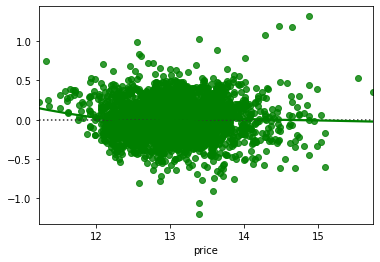

In [87]:
sns.residplot(x = y_test1, y=y_pred_ridge, lowess=True, color = 'g')

## Step 7: Evaluate your different models in order to determine the best model overall.

In [88]:
print('Model 1: Training RMSE: ', int(train_rmse), 'vs. Testing RMSE: ', int(test_rmse), '- No feature selection or scaling')
print('\nModel 2: Training RMSE: ', str(round(trainK_rmse, 3)), 'vs. Testing RMSE: ', str(round(testK_rmse, 3)), '- Kbest feature selection, target log and scaling')
print('\nModel 3: Training RMSE: ', str(round(trainRFE_rmse, 3)), 'vs. Testing RMSE: ', str(round(testRFE_rmse, 3)), '- Recursive feature selection, target log and scaling')
print('\nModel 4: Training RMSE: ', str(round(train_rmse_ridge, 3)), 'vs. Testing RMSE: ', str(round(test_rmse_ridge, 3)), '- kbest feature selection, Ridge , target log and scaling')

Model 1: Training RMSE:  89387 vs. Testing RMSE:  153922 - No feature selection or scaling

Model 2: Training RMSE:  189672.13 vs. Testing RMSE:  213527.538 - Kbest feature selection, target log and scaling

Model 3: Training RMSE:  189679.187 vs. Testing RMSE:  213446.264 - Recursive feature selection, target log and scaling

Model 4: Training RMSE:  189688.759 vs. Testing RMSE:  213428.8 - kbest feature selection, Ridge , target log and scaling


## <center> Model Interpretation<center/>

Basic linear Regression with no feature selection had the lowest Root Mean Square Error (RMSE) error value. These means that Model number 1 was better than the other models at prediction home prices on useen data. From the data set analysis and model coefficients, the features the have the highest impact on home prices are square foot living, number of bathrooms, number of bedrooms, grade, and condition. 

## Step 8:  Refit your best model to the entire dataset.

In [89]:
linreg_final = LinearRegression()

linreg_final = linreg.fit(df_poly, df['price'])

In [90]:
linreg_final.coef_

array([-2.08136275e+03,  2.71969356e+04,  1.10284921e+05, ...,
       -1.96322589e+02, -2.42355072e+06, -2.43093515e+03])

In [91]:
final_scaler =StandardScaler()

#fit and transform the training data
df_final_scaled = pd.DataFrame(data=final_scaler.fit_transform(df_poly[selected_rfe]), columns=selected_rfe)

In [92]:
linreg_ridge_final = LinearRegression()

linreg_ridge_final = linreg_ridge_final.fit(df_final_scaled, target_log)

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [97]:
import pickle

pickle_out = open("models/model.pickle", "wb")
pickle.dump(linreg_final, pickle_out)
pickle_out.close()

In [98]:
import pickle

pickle_out = open("models/ridge_model.pickle", "wb")
pickle.dump(linreg_ridge_final, pickle_out)
pickle_out.close()

In [99]:
pickle_out = open('models/scaler.pickle', "wb")
pickle.dump(final_scaler, pickle_out)
pickle_out.close()